In [1]:
from scipy.interpolate import PchipInterpolator
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef, roc_auc_score
from skopt.space import Integer, Real
from skopt.utils import use_named_args
from skopt import gp_minimize

/Users/cuongthai/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
data = pd.read_csv('/Users/cuongthai/Downloads/data.csv')
data.shape

(42372, 1036)

In [3]:
# Kiểm tra các hàng mà tất cả các giá trị (ngoại trừ cột mã khách hàng và cột FLAG) đều là NaN
condition = ((data.iloc[:, 2:].isnull() | (data.iloc[:, 2:] == 0)).all(axis=1))

print(f"Number of customers whose values ​​are all NaN or 0: {condition.sum()*100/data.shape[0]:.2f} %")

# Loại bỏ các hàng thỏa mãn điều kiện trên
data = data[~condition]
# Hiển thị số lượng khách hàng còn lại trong tập dữ liệu sau khi loại bỏ
print(f"Number of customers after removal: {data.shape[0]}")

# Đếm số lượng khách hàng có FLAG = 0
flag_0_count = data[data['FLAG'] == 0].shape[0]
print(f"Number of customers with FLAG = 0: {flag_0_count}")

# Đếm số lượng khách hàng có FLAG = 1
flag_1_count = data[data['FLAG'] == 1].shape[0]
print(f"Number of customers with FLAG = 1: {flag_1_count}")

Number of customers whose values ​​are all NaN or 0: 4.99 %
Number of customers after removal: 40258
Number of customers with FLAG = 0: 36679
Number of customers with FLAG = 1: 3579


/var/folders/y0/gyb72m0n71v9pjbcrcfgfpf00000gn/T/ipykernel_35147/3514539242.py:2: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data.columns = pd.to_datetime(data.columns, errors='ignore')
/var/folders/y0/gyb72m0n71v9pjbcrcfgfpf00000gn/T/ipykernel_35147/3514539242.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data.columns = pd.to_datetime(data.columns, errors='ignore')


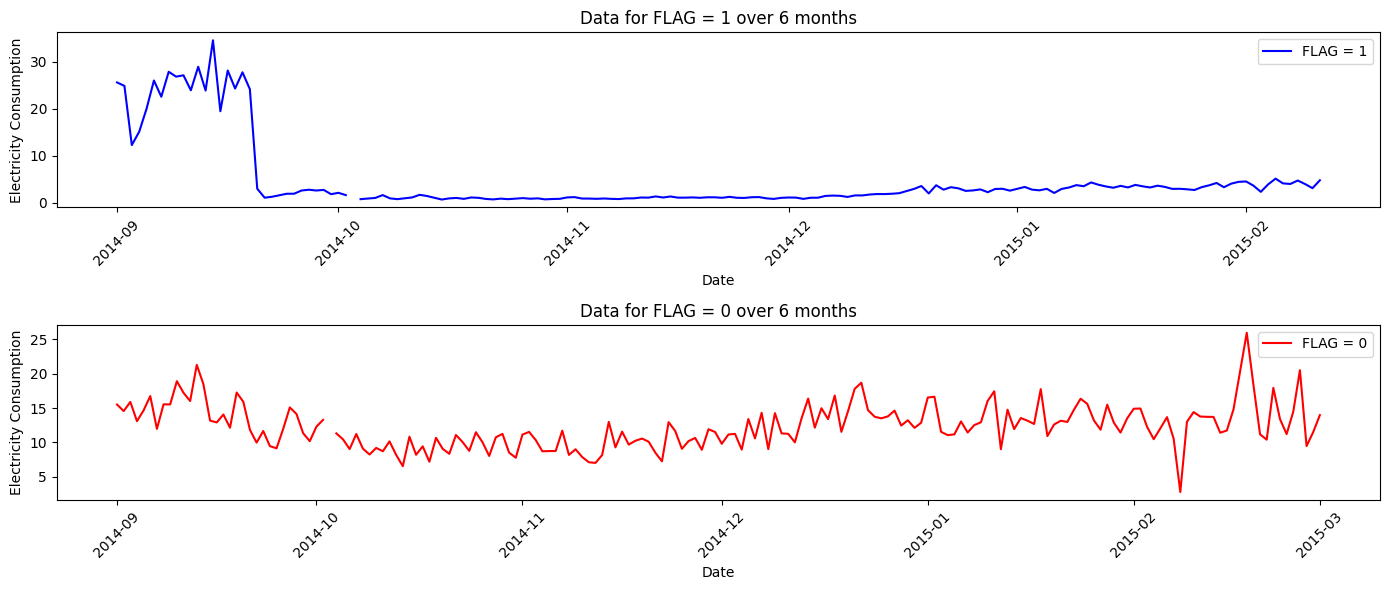

In [4]:
# Chuyển các cột ngày tháng thành kiểu ngày tháng
data.columns = pd.to_datetime(data.columns, errors='ignore')

# Chọn 1 hàng có FLAG = 1 và 1 hàng có FLAG = 0
row_flag_1 = data[data['FLAG'] == 1].drop(columns=['FLAG', 'CONS_NO']).iloc[2]
row_flag_0 = data[data['FLAG'] == 0].drop(columns=['FLAG', 'CONS_NO']).iloc[1]
row_flag_1.index = pd.to_datetime(row_flag_1.index)
row_flag_0.index = pd.to_datetime(row_flag_0.index)
start_date = '2014/9/1'  # Ngày bắt đầu của 6 tháng
end_date = '2015/3/1'   # Ngày kết thúc của 6 tháng
date_range = pd.date_range(start=start_date, end=end_date)
# Lọc dữ liệu theo ngày
row_flag_1_6m = row_flag_1[date_range]
row_flag_0_6m = row_flag_0[date_range]

# Vẽ đồ thị
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(row_flag_1_6m.index, row_flag_1_6m.values, label='FLAG = 1', color='blue')
plt.title('Data for FLAG = 1 over 6 months')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.xticks(rotation=45)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(row_flag_0_6m.index, row_flag_0_6m.values, label='FLAG = 0', color='red')
plt.title('Data for FLAG = 0 over 6 months')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

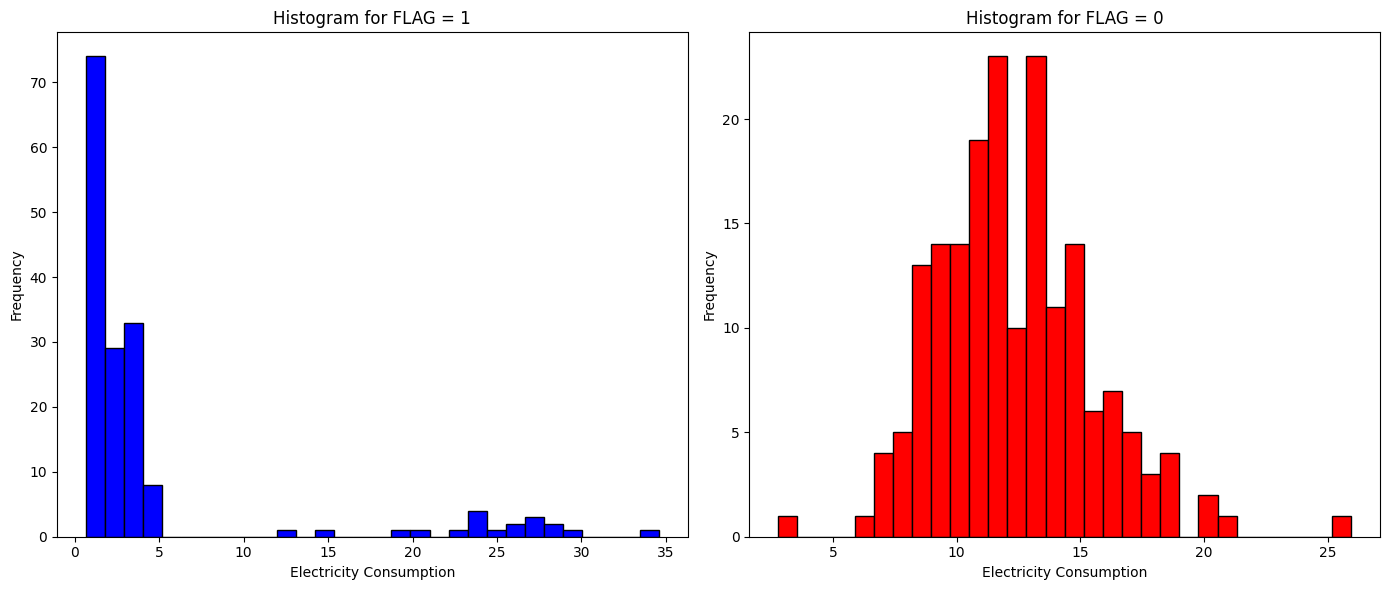

In [5]:
# Vẽ histogram cho row_flag_1_6m và row_flag_0_6m
plt.figure(figsize=(14, 6))

# Histogram cho FLAG = 1
plt.subplot(1, 2, 1)
plt.hist(row_flag_1_6m, bins=30, color='blue', edgecolor='black')
plt.title('Histogram for FLAG = 1')
plt.xlabel('Electricity Consumption')
plt.ylabel('Frequency')

# Histogram cho FLAG = 0
plt.subplot(1, 2, 2)
plt.hist(row_flag_0_6m, bins=30, color='red', edgecolor='black')
plt.title('Histogram for FLAG = 0')
plt.xlabel('Electricity Consumption')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [6]:
def check_outliers_mad(series):
    # Tính trung vị của dữ liệu
    median = series.median()
    
    # Tính độ lệch tuyệt đối so với trung vị
    abs_deviation = np.abs(series - median)
    
    # Tính Độ lệch tuyệt đối trung vị (MAD)
    mad = abs_deviation.median()
    
    # Xác định giá trị outlier
    outliers = series[np.abs(series - median) > 3 * mad]
    
    return outliers

# Áp dụng hàm cho row_flag_1_6m và row_flag_0_6m
outliers_flag_1 = check_outliers_mad(row_flag_1_6m).sum()
outliers_flag_0 = check_outliers_mad(row_flag_0_6m).sum()

print("Outliers in row_flag_1_6m: ", round(outliers_flag_1 * 100 / row_flag_1_6m.sum(), 2), "%")
print("Outliers in row_flag_0_6m: ", round(outliers_flag_0 * 100 / row_flag_0_6m.sum(), 2), "%")

Outliers in row_flag_1_6m:  61.21 %
Outliers in row_flag_0_6m:  9.81 %


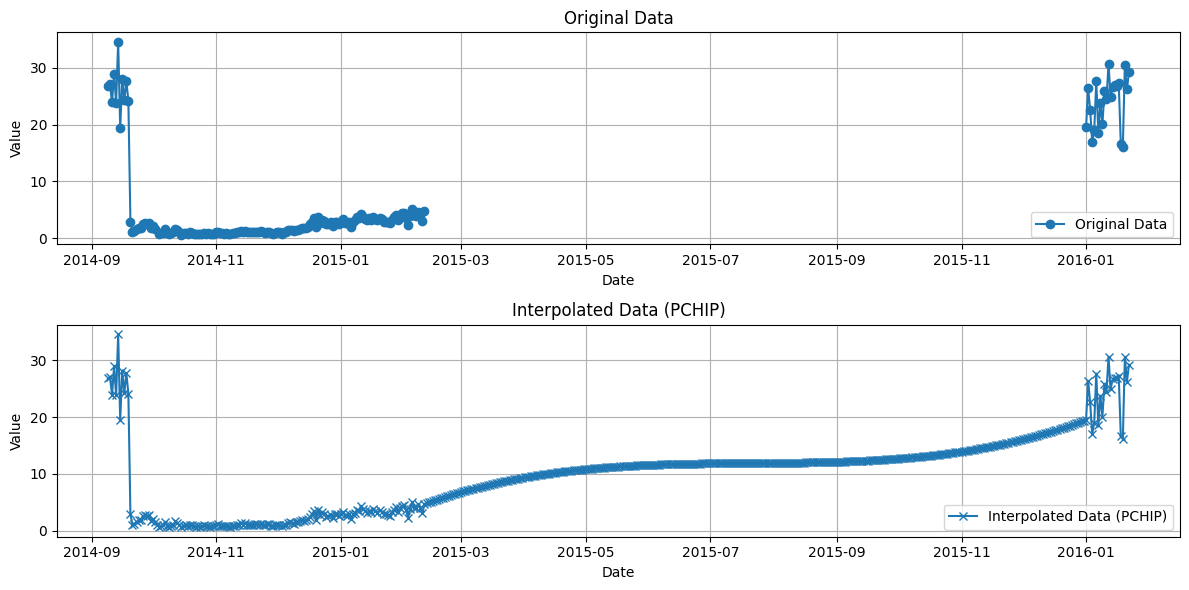

In [7]:
# Chọn dữ liệu trong khoảng thời gian 200 ngày
def get_data_in_period(data, start_date, num_days):
    end_date = pd.to_datetime(start_date) + pd.DateOffset(days=num_days)
    date_range = pd.date_range(start=start_date, end=end_date)
    return data[date_range]

# Hàm nội suy sử dụng PCHIP
def interpolate_pchip(series):
    # Lấy index không phải NaN và giá trị tương ứng
    non_nan_indices = series.dropna().index
    non_nan_values = series.dropna().values
    
    # Tạo đối tượng PCHIP với các điểm không NaN
    pchip = PchipInterpolator(non_nan_indices, non_nan_values)
    
    # Nội suy các giá trị NaN
    interpolated_values = pchip(series.index)
    
    # Trả về chuỗi dữ liệu với các giá trị đã được nội suy
    return pd.Series(interpolated_values, index=series.index)

# Lấy dữ liệu trong khoảng thời gian 200 ngày cho row_flag_1
start_date = '2014/9/9'
num_days = 500
row_flag_1_200d = get_data_in_period(row_flag_1, start_date, num_days)

# Nội suy các giá trị NaN bằng PCHIP
row_flag_1_200d_interpolated = interpolate_pchip(row_flag_1_200d)

# Vẽ dữ liệu ban đầu và dữ liệu đã được nội suy trên hai biểu đồ riêng biệt
plt.figure(figsize=(12, 6))

# Biểu đồ 1: Dữ liệu ban đầu
plt.subplot(2, 1, 1)
plt.plot(row_flag_1_200d.index, row_flag_1_200d, 'o-', label='Original Data')
plt.title('Original Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Biểu đồ 2: Dữ liệu đã được nội suy
plt.subplot(2, 1, 2)
plt.plot(row_flag_1_200d_interpolated.index, row_flag_1_200d_interpolated, 'x-', label='Interpolated Data (PCHIP)')
plt.title('Interpolated Data (PCHIP)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
# Tính tổng số khách hàng
total_customers = data['FLAG'].count()

# Đếm số lượng khách hàng có flag = 0
count_flag_0 = data[data['FLAG'] == 0]['FLAG'].count()

# Đếm số lượng khách hàng có flag = 1
count_flag_1 = data[data['FLAG'] == 1]['FLAG'].count()

# Tính phần trăm khách hàng có flag = 0
percentage_flag_0 = (count_flag_0 / total_customers) * 100

# Tính phần trăm khách hàng có flag = 1
percentage_flag_1 = (count_flag_1 / total_customers) * 100

# In kết quả
print(f"Percentage of customers with flag = 0: {percentage_flag_0:.2f}%")
print(f"Percentage of customers with flag = 1: {percentage_flag_1:.2f}%")
print(f"Difference: {count_flag_0 - count_flag_1}")

Percentage of customers with flag = 0: 91.11%
Percentage of customers with flag = 1: 8.89%
Difference: 33100


In [9]:
def pchip_interpolation(series):
    # Lấy chỉ số các giá trị không NaN
    not_nan = np.where(~np.isnan(series))[0]
    # Lấy giá trị không NaN tương ứng
    values = series[not_nan]
    
    # Tạo đối tượng PCHIP interpolator
    pchip = PchipInterpolator(not_nan, values)
    
    # Nội suy và thay thế các giá trị NaN
    interpolated_series = pchip(np.arange(len(series)))
    return interpolated_series

p = count_flag_0 - count_flag_1
observations_flag_0 = data[data['FLAG'] == 0]
observations_flag_0 = observations_flag_0.drop(observations_flag_0.columns[:2], axis=1)

O = observations_flag_0.sample(n=p, random_state=1).iloc[:, :1034].values

C = np.random.rand(p, 1034)

#Hadamard
Os = C * O

# #Chuyển ma trận Os thành DataFrame
df_Os = pd.DataFrame(Os)

df_Os.insert(0, None, [f'CONS_NO_{i}' for i in range(p)])

# Bước 3: Thêm cột với giá trị cố định là '1'
df_Os.insert(1, None, 1)
df_Os.columns = data.columns
# Hợp nhất dữ liệu Os vào DataFrame gốc đã tách
time_domain_synthetic_data = pd.concat([data, df_Os], ignore_index=True)
# Áp dụng PCHIP interpolation cho từng cột dữ liệu (bỏ qua cột mã khách hàng và FLAG)
time_domain_synthetic_data.iloc[:, 2:] = time_domain_synthetic_data.iloc[:, 2:].apply(pchip_interpolation, axis=0)

time_domain_synthetic_data

,CONS_NO,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
0,0387DD8A07E07FDA6271170F86AD9151,1,18.828750,13.686250,19.075000,15.103750,36.320000,42.522500,25.057500,47.551250,...,10.120000,9.960000,16.920000,7.600000,27.220000,18.050000,26.470000,18.750000,17.840000,14.920000
1,4B75AC4F2D8434CFF62DB64D0BB43103,1,11.816667,9.996667,12.876667,12.163333,19.240000,23.270000,15.746667,24.600000,...,6.952500,9.966959,12.689167,16.231250,27.126034,18.505000,17.761667,13.662917,19.083750,15.225986
2,B32AC8CC6D5D805AC053557AB05F5343,1,6.541250,6.443750,7.725000,8.366250,8.880000,11.037500,8.722500,10.678750,...,6.500000,9.990000,11.780000,18.590000,26.800000,18.570000,14.590000,12.820000,19.370000,15.920000
3,EDFC78B07BA2908B3395C4EB2304665E,1,2.900000,3.420000,3.810000,4.580000,3.560000,4.250000,3.860000,3.530000,...,17.770000,10.370000,15.320000,13.510000,12.230000,14.680000,16.350000,18.140000,18.410000,17.310000
4,6BCFD78138BC72A9BA1BFB0B79382192,1,0.790417,1.317917,1.321667,1.672083,1.600000,1.332500,1.034167,0.896250,...,2.820000,5.520000,3.120000,3.130000,4.200000,3.230000,3.850000,2.780000,3.550000,2.540000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73353,CONS_NO_33095,1,0.000000,0.000188,0.000000,0.002143,0.008551,0.006230,0.000000,0.000796,...,0.027338,1.052021,0.000000,0.007668,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
73354,CONS_NO_33096,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.949762,0.000000,0.110322,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
73355,CONS_NO_33097,1,0.420242,0.047103,0.421016,1.168753,0.185524,0.374063,0.738452,0.584935,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
73356,CONS_NO_33098,1,1.560900,0.175006,1.563773,4.341696,0.691534,1.391158,2.742820,2.172844,...,12.303203,13.873153,3.793003,8.446589,7.626926,27.723589,10.103156,27.831496,18.328306,2.449960


In [10]:
# Hàm chuẩn hóa
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

# Áp dụng hàm chuẩn hóa cho các cột giá trị điện năng tiêu thụ
time_domain_synthetic_data.iloc[:, 2:] = time_domain_synthetic_data.iloc[:, 2:].apply(pd.to_numeric, errors='coerce').apply(normalize)
time_domain_synthetic_data

,CONS_NO,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
0,0387DD8A07E07FDA6271170F86AD9151,1,0.005675,3.450895e-03,0.004343,4.424063e-03,3.917428e-04,0.013427,0.006328,1.301348e-02,...,0.001600,0.001425,0.001156,0.001139,1.667892e-03,0.001056,0.001248,0.001045,0.001068,0.000803
1,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.003561,2.520592e-03,0.002932,3.562781e-03,2.075201e-04,0.007348,0.003976,6.732348e-03,...,0.001099,0.001426,0.000867,0.002433,1.662134e-03,0.001082,0.000837,0.000762,0.001142,0.000820
2,B32AC8CC6D5D805AC053557AB05F5343,1,0.001971,1.624748e-03,0.001759,2.450571e-03,9.577852e-05,0.003485,0.002203,2.922482e-03,...,0.001028,0.001429,0.000805,0.002786,1.642157e-03,0.001086,0.000688,0.000715,0.001159,0.000857
3,EDFC78B07BA2908B3395C4EB2304665E,1,0.000874,8.623298e-04,0.000867,1.341535e-03,3.839769e-05,0.001342,0.000975,9.660646e-04,...,0.002810,0.001484,0.001046,0.002025,7.493873e-04,0.000858,0.000771,0.001011,0.001102,0.000932
4,6BCFD78138BC72A9BA1BFB0B79382192,1,0.000238,3.323037e-04,0.000301,4.897725e-04,1.725739e-05,0.000421,0.000261,2.452791e-04,...,0.000446,0.000790,0.000213,0.000469,2.573529e-04,0.000189,0.000182,0.000155,0.000212,0.000137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73353,CONS_NO_33095,1,0.000000,4.747579e-08,0.000000,6.277123e-07,9.222648e-08,0.000002,0.000000,2.177091e-07,...,0.000004,0.000151,0.000000,0.000001,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
73354,CONS_NO_33096,1,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.000279,0.000000,0.000017,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
73355,CONS_NO_33097,1,0.000127,1.187660e-05,0.000096,3.423414e-04,2.001043e-06,0.000118,0.000186,1.600808e-04,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
73356,CONS_NO_33098,1,0.000470,4.412664e-05,0.000356,1.271733e-03,7.458794e-06,0.000439,0.000693,5.946481e-04,...,0.001945,0.001985,0.000259,0.001266,4.673361e-04,0.001621,0.000476,0.001551,0.001097,0.000132


In [11]:
# Chuyển các giá trị sang định dạng số
data_values = time_domain_synthetic_data.iloc[:, 2:].apply(pd.to_numeric, errors='coerce').fillna(0)

# Thực hiện DFT cho từng hàng của data_values
dft_results = np.fft.fft(data_values, axis=1)

# Chuyển kết quả DFT thành DataFrame
dft_df = pd.DataFrame(dft_results, columns=[f'DFT_{i}' for i in range(dft_results.shape[1])])

# Áp dụng hàm chuẩn hóa cho các cột giá trị điện năng tiêu thụ
magnitude = dft_df.applymap(np.abs)
normalized_magnitude = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min())
frequency_domain_synthetic_data = pd.concat([time_domain_synthetic_data.iloc[:, :2], normalized_magnitude], axis=1)
frequency_domain_synthetic_data


/var/folders/y0/gyb72m0n71v9pjbcrcfgfpf00000gn/T/ipykernel_35147/1512615944.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  magnitude = dft_df.applymap(np.abs)


,CONS_NO,FLAG,DFT_0,DFT_1,DFT_2,DFT_3,DFT_4,DFT_5,DFT_6,DFT_7,...,DFT_1024,DFT_1025,DFT_1026,DFT_1027,DFT_1028,DFT_1029,DFT_1030,DFT_1031,DFT_1032,DFT_1033
0,0387DD8A07E07FDA6271170F86AD9151,1,0.016277,0.007271,0.020369,0.039008,0.003976,0.031165,0.014789,0.008807,...,0.059646,0.015859,0.043400,0.008807,0.014789,0.031165,0.003976,0.039008,0.020369,0.007271
1,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.011160,0.003676,0.013833,0.024509,0.004276,0.021822,0.014343,0.010595,...,0.047043,0.012901,0.031194,0.010595,0.014343,0.021822,0.004276,0.024509,0.013833,0.003676
2,B32AC8CC6D5D805AC053557AB05F5343,1,0.008592,0.001716,0.009156,0.018856,0.006824,0.014109,0.014505,0.016277,...,0.039485,0.017655,0.023472,0.016277,0.014505,0.014109,0.006824,0.018856,0.009156,0.001716
3,EDFC78B07BA2908B3395C4EB2304665E,1,0.006156,0.003718,0.009071,0.015483,0.008227,0.015634,0.018596,0.020757,...,0.039638,0.021881,0.019945,0.020757,0.018596,0.015634,0.008227,0.015483,0.009071,0.003718
4,6BCFD78138BC72A9BA1BFB0B79382192,1,0.004128,0.003784,0.008533,0.015740,0.008894,0.016837,0.020851,0.021276,...,0.037874,0.022666,0.017500,0.021276,0.020851,0.016837,0.008894,0.015740,0.008533,0.003784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73353,CONS_NO_33095,1,0.002205,0.001975,0.003178,0.005143,0.002804,0.001265,0.000793,0.001919,...,0.001818,0.001972,0.001795,0.001919,0.000793,0.001265,0.002804,0.005143,0.003178,0.001975
73354,CONS_NO_33096,1,0.000033,0.000258,0.000299,0.000468,0.000656,0.001243,0.000517,0.000736,...,0.001042,0.000844,0.000371,0.000736,0.000517,0.001243,0.000656,0.000468,0.000299,0.000258
73355,CONS_NO_33097,1,0.000108,0.000275,0.000279,0.000436,0.000679,0.001262,0.000468,0.000739,...,0.001091,0.000584,0.000518,0.000739,0.000468,0.001262,0.000679,0.000436,0.000279,0.000275
73356,CONS_NO_33098,1,0.001068,0.000529,0.000484,0.001284,0.001103,0.002062,0.001575,0.001081,...,0.003561,0.001198,0.001235,0.001081,0.001575,0.002062,0.001103,0.001284,0.000484,0.000529


In [14]:
# Chuẩn bị dữ liệu
def prepare_data():
    X = frequency_domain_synthetic_data.iloc[:, 2:].values
    y = frequency_domain_synthetic_data.iloc[:, 1].values
    
    # Chia dữ liệu thành 80% training và 20% testing
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Tiếp tục chia tập training thành 80% training và 20% validation
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test


# Xây dựng mô hình với các siêu tham số đã chọn
def build_model(input_dim, n_hidden_layers, layer_size, regularization_strength):
    model = tf.keras.models.Sequential()
    
    # Tầng đầu vào
    model.add(tf.keras.layers.Input(shape=(input_dim,)))
    
    # Tầng ẩn đầu tiên
    model.add(tf.keras.layers.Dense(layer_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_strength)))
    
    # Các tầng ẩn tiếp theo dựa trên n_hidden_layers
    for i in range(n_hidden_layers - 1):
        model.add(tf.keras.layers.Dense(layer_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(regularization_strength)))
    
    # Tầng đầu ra
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    # Biên dịch mô hình với Adam optimizer và binary cross-entropy loss
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


def objective_wrapper(X_train, y_train, X_val, y_val):
    @use_named_args(dimensions=[
        Integer(1, 3, name='n_hidden_layers'),
        Integer(10, 500, name='layer_size'),
        Real(1e-8, 1e-2, "log-uniform", name='regularization_strength'),  # Hệ số regularization
    ])
    def objective(n_hidden_layers, layer_size, regularization_strength):
        print(f"Đang thử nghiệm với n_hidden_layers: {n_hidden_layers}, layer_size: {layer_size}, regularization_strength: {regularization_strength}...")
        # Xây dựng mô hình với các siêu tham số hiện tại
        model = build_model(X_train.shape[1], n_hidden_layers, layer_size, regularization_strength)
        
        # Huấn luyện mô hình với số epoch nhỏ
        model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_data=(X_val, y_val))
        
        # Dự đoán trên tập validation
        y_pred = (model.predict(X_val) > 0.5).astype("int32")
        
        # Tính toán độ chính xác là chỉ số để tối ưu
        accuracy = accuracy_score(y_val, y_pred)
        print(f"Độ chính xác trên tập validation: {accuracy:.4f}")
        
        # Trả về giá trị độ chính xác âm vì gp_minimize cần tối thiểu hóa hàm mục tiêu
        return -accuracy
    
    return objective  # Trả về hàm objective thay vì gọi trực tiếp


def optimize_hyperparameters(X_train, y_train, X_val, y_val):
    print("Bắt đầu quá trình tối ưu hóa các siêu tham số bằng Bayesian optimization...")
    objective = objective_wrapper(X_train, y_train, X_val, y_val)  # Lấy hàm mục tiêu từ wrapper
    
    res_gp = gp_minimize(
        func=objective,
        dimensions=[
            Integer(1, 3, name='n_hidden_layers'),
            Integer(10, 500, name='layer_size'),
            Real(1e-8, 1e-2, "log-uniform", name='regularization_strength'),
        ],
        n_calls=100,  # Số lượng bước tối ưu hóa
        random_state=42
    )
    
    print(f"\nCác siêu tham số tốt nhất tìm thấy: {res_gp.x}")
    print(f"Độ chính xác tốt nhất trên tập validation: {-res_gp.fun:.4f}\n")
    
    return res_gp.x  # Trả về các siêu tham số tốt nhất


# Huấn luyện mô hình cuối cùng với các siêu tham số tốt nhất
def train_final_model(X_train_val, y_train_val, X_test, y_test, best_params):
    print("Bắt đầu huấn luyện mô hình cuối cùng với các siêu tham số tốt nhất...")
    n_hidden_layers = best_params[0]
    layer_size = best_params[1]
    regularization_strength = best_params[2]
    
    model = build_model(X_train_val.shape[1], layer_size, n_hidden_layers, regularization_strength)
    
    model.fit(X_train_val, y_train_val, epochs=100, batch_size=128, validation_data=(X_test, y_test))
    
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Độ chính xác cuối cùng trên tập kiểm tra: {accuracy:.4f}\n")

    # Lưu lại mô hình đã huấn luyện
    model.save('final_model.h5')
    print("Mô hình đã được lưu lại với tên 'final_model.h5'")
    
    return model, y_pred


# Đánh giá các chỉ số hiệu suất mô hình
def evaluate_model_performance(y_true, y_pred, y_prob):
    print("Đánh giá hiệu suất mô hình...")
    recall = recall_score(y_true, y_pred, average=None)
    precision = precision_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    mcc = matthews_corrcoef(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_prob)
    
    results = {
        "Recall": recall,
        "Precision": precision,
        "F1-Score": f1,
        "Accuracy": accuracy,
        "AUC-ROC": auc_roc,
        "MCC": mcc
    }

    return results


def create_results_table(results, phases):
    categories = ["Recall", "Precision", "F1-Score", "Accuracy", "AUC-ROC", "MCC"]
    classes = ["Faithful", "Unfaithful"]
    multi_index = pd.MultiIndex.from_product([categories, classes], names=["Metric", "Class"])
    
    table = pd.DataFrame(index=multi_index, columns=phases)

    for phase in phases:
        for i, class_label in enumerate(classes):
            table.loc[("Recall", class_label), phase] = results[phase]["Recall"][i]
            table.loc[("Precision", class_label), phase] = results[phase]["Precision"][i]
            table.loc[("F1-Score", class_label), phase] = results[phase]["F1-Score"][i]
        
        # Kiểm tra và thêm các giá trị không NaN của các chỉ số chung
        if pd.notna(results[phase]["Accuracy"]):
            table.loc[("Accuracy", ""), phase] = results[phase]["Accuracy"]
        if pd.notna(results[phase]["AUC-ROC"]):
            table.loc[("AUC-ROC", ""), phase] = results[phase]["AUC-ROC"]
        if pd.notna(results[phase]["MCC"]):
            table.loc[("MCC", ""), phase] = results[phase]["MCC"]

    # Loại bỏ các hàng NaN trong bảng
    table.dropna(how='all', inplace=True)

    return table


if __name__ == "__main__":
    # Bước 1: Chuẩn bị dữ liệu
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data()

    # Bước 2: Tối ưu hóa các siêu tham số bằng Bayesian optimization
    best_params = optimize_hyperparameters(X_train, y_train, X_val, y_val)

    # Bước 3: Huấn luyện mô hình cuối cùng với các siêu tham số tốt nhất
    final_model, y_pred_test = train_final_model(X_train, y_train, X_test, y_test, best_params)
    
    # Đánh giá trên tập kiểm tra
    print("Bắt đầu đánh giá trên tập kiểm tra...")
    y_prob_test = final_model.predict(X_test).ravel()
    test_results = evaluate_model_performance(y_test, y_pred_test, y_prob_test)
    
    # Đánh giá trên tập validation
    print("Bắt đầu đánh giá trên tập validation...")
    y_pred_val = (final_model.predict(X_val) > 0.5).astype("int32")
    y_prob_val = final_model.predict(X_val).ravel()
    val_results = evaluate_model_performance(y_val, y_pred_val, y_prob_val)
    
    # Tạo bảng kết quả
    results = {
        "Validation": val_results,
        "Test": test_results
    }

    phases = ["Validation", "Test"]
    
    results_table = create_results_table(results, phases)
    print(results_table)

Bắt đầu quá trình tối ưu hóa các siêu tham số bằng Bayesian optimization...
Đang thử nghiệm với n_hidden_layers: 3, layer_size: 100, regularization_strength: 0.00047659118086808527...
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step
Độ chính xác trên tập validation: 0.9359
Đang thử nghiệm với n_hidden_layers: 2, layer_size: 228, regularization_strength: 3.9796923010559875e-08...
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
Độ chính xác trên tập validation: 0.9474
Đang thử nghiệm với n_hidden_layers: 2, layer_size: 174, regularization_strength: 7.197818769068857e-08...
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step
Độ chính xác trên tập validation: 0.9323
Đang thử nghiệm với n_hidden_layers: 2, layer_size: 38, regularization_strength: 0.00021477940434530936...
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
Độ chính xác trên tập validation: 0.9320
Đang thử nghiệm với n_hidden_layers: 3, layer_size: 10, regularization_strength: 0.008979855655182448...
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
Độ chính x

Độ chính xác cuối cùng trên tập kiểm tra: 0.9447

Mô hình đã được lưu lại với tên 'final_model.h5'
Bắt đầu đánh giá trên tập kiểm tra...
459/459 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step
Đánh giá hiệu suất mô hình...
Bắt đầu đánh giá trên tập validation...
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step
Đánh giá hiệu suất mô hình...
                     Validation      Test
Metric    Class                          
Recall    Faithful          1.0       1.0
          Unfaithful   0.888112  0.889418
Precision Faithful     0.899556  0.900258
          Unfaithful        1.0       1.0
F1-Score  Faithful     0.947122  0.947511
          Unfaithful   0.940741  0.941473
Accuracy               0.944113  0.944656
AUC-ROC                0.949066  0.949526
MCC                    0.893816  0.894822
